## Raman Transitions between Groundstates Induced by Probing Light

References:

Decay rate and optical Bloch eqns: https://steck.us/alkalidata/cesiumnumbers.pdf

Raman transitions: https://arxiv.org/pdf/1802.03640.pdf

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [148]:
# 3P1 linewidth 
Gamma = 182e3 * 2 * np.pi

# I_sat: 0.14 W/cm^2
I_sat = 0.14

# Branching ratio:
# --    --    --  --
#  \    |     /
#   1  2/3  1/3
#       --

In [369]:
def Freq_offset(B=5):
    return (np.array([0, 3, 3, 0]) + 1.4*B*np.array([0, 1, 2, 3]))*2e6*np.pi

def R_sc(detuning, I=I_sat):
    return Gamma/2*(I/I_sat)/(1+4*(detuning/Gamma)**2+I/I_sat)

def Omega_Raman(B=5, I=I_sat):
    Omega_s2p = Gamma*np.sqrt(I/(3*2*I_sat))
    Omega_m1h = np.sqrt(2/3*1/3)*Omega_s2p**2/(2*Freq_offset(B)[1])
    Omega_p1h = np.sqrt(2/3*1/3)*Omega_s2p**2/(2*Freq_offset(B)[2])
    Omega = Omega_m1h+Omega_p1h
    return Omega

In [370]:
def H_op(tList, B=5, I=I_sat, is_Raman=True, is_decay=True):
    # Raman transitions b/w ground states with gs Zeeman splitting as detuning 
    if is_Raman:
        H = Omega_Raman(B, I)/2*sigmax()+B*2*np.pi*650*sigmaz()/2
    else:
        H = qeye(2)
    
    # With spontaneous emission
    # +-1/2 -> +-1/2: dephasing (T2)
    # +-1/2 -> -+1/2: amplitude damping (T1)
    if is_decay:
        det_list = Freq_offset(B)
    
        # Decay rate b/w ground states via P states
        def R_11(_I):
            sc_0 = 1*R_sc(det_list[0], _I*1/3)
            sc_1 = 2/3*R_sc(det_list[1], _I*1/3*2/3)
            sc_2 = 1/3*R_sc(det_list[2], _I*1/3*1/3)
            return sc_0+sc_1+sc_2
        
        def R_12(_I):
            sc_1 = 1/3*R_sc(det_list[1], _I*1/3*2/3)
            sc_2 = 2/3*R_sc(det_list[2], _I*1/3*1/3)
            return sc_1+sc_2

        def R_21(_I):
            sc_2 = 1/3*R_sc(det_list[2], _I*1/3*2/3)
            sc_1 = 2/3*R_sc(det_list[1], _I*1/3*1/3)
            return sc_2+sc_1
        
        def R_22(_I):
            sc_1 = 1/3*R_sc(det_list[1], _I*1/3*1/3)
            sc_2 = 2/3*R_sc(det_list[2], _I*1/3*2/3)
            sc_3 = 1*R_sc(det_list[3], _I*1/3)
            return sc_1+sc_2+sc_3
        
        c_ops = [
            np.sqrt(2*R_12(I))*sigmap(),          # -1/2 -> +1/2
            np.sqrt(2*R_21(I))*sigmam(),          # +1/2 -> -1/2
            np.sqrt(2*R_11(I))*fock_dm(2, 0),     # -1/2 -> -1/2
            np.sqrt(2*R_22(I))*fock_dm(2, 1),     # +1/2 -> +1/2
        ]
    else: # Just Raman, no decay
        c_ops = []
        
    # Initial state
    psi_0 = fock(2, 0)
    
    # return expectations on S +-1/2 states
    return mesolve(H, psi_0, tList, c_ops, [fock_dm(2, 0), fock_dm(2, 1)]).expect

In [371]:
tList = np.linspace(0, .1, 201)
_I = 1*I_sat
_is_decay = True
# _is_Raman = True
_B = 40

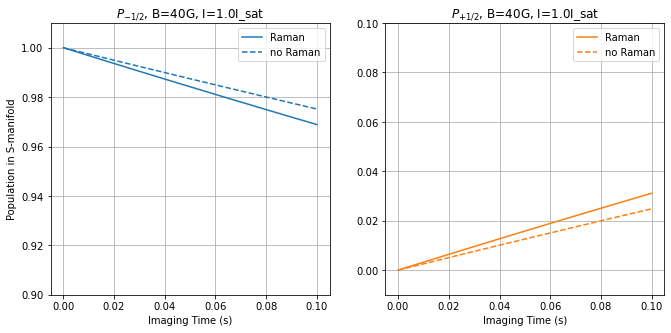

In [372]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

ax[0].plot(tList, H_op(tList, B=_B, I=_I, is_Raman=True, is_decay=_is_decay)[0], color='tab:blue', label='Raman')
ax[0].plot(tList, H_op(tList, B=_B, I=_I, is_Raman=False, is_decay=_is_decay)[0], '--',
         color='tab:blue', label='no Raman')
ax[1].plot(tList, H_op(tList, B=_B, I=_I, is_Raman=True, is_decay=_is_decay)[1], color='tab:orange', label='Raman')
ax[1].plot(tList, H_op(tList, B=_B, I=_I, is_Raman=False, is_decay=_is_decay)[1], '--',
         color='tab:orange', label='no Raman')

ax[0].set_ylim([0.9, 1.01])
ax[1].set_ylim([-0.01, 0.1])
ax[0].set_title('$P_{-1/2}$, B='+str(_B)+'G, I='+str(I/I_sat)+'I_sat')
ax[1].set_title('$P_{+1/2}$, B='+str(_B)+'G, I='+str(I/I_sat)+'I_sat')
ax[0].set_ylabel('Population in S-manifold')

for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Imaging Time (s)")

Some effect from Raman when considering -3/2 imaging.